In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/train (1).csv')

In [ ]:
# Show shape and first few rows
print("Shape:", df.shape)
df.head()

Shape: (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount= True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


In [ ]:
df.shape

(159571, 8)

In [ ]:
# Check for missing values
print(df.isnull().sum())

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [ ]:
# Check label distribution
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print(df[label_cols].sum())

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


 ## Takeaways:

Highly imbalanced data — majority of comments are non-toxic (approx 90%)

The ‘threat’ and ‘identity_hate’ categories are especially rare

Toxic is the most common toxic label and will be good as a starting point if doing binary classification first (toxic vs. not)

In [ ]:
# Example of a toxic comment
print("\nSample toxic comment:")
print(df[df['toxic'] == 1]['comment_text'].values[0])


Sample toxic comment:
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK


In [ ]:
import nltk
import re
import string
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove line breaks and tabs
    text = re.sub(r'\n|\r|\t', ' ', text)
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove user mentions and hashtags
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuations and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in STOPWORDS]
    return " ".join(tokens)


In [ ]:
df['cleaned_comment'] = df['comment_text'].apply(clean_text)

# Show before & after
for i in range(2):
    print("\nOriginal:", df['comment_text'][i])
    print("Cleaned :", df['cleaned_comment'][i])



Original: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Cleaned : explanation edits made username hardcore metallica fan reverted werent vandalisms closure gas voted new york dolls fac please dont remove template talk page since im retired

Original: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Cleaned : daww matches background colour im seemingly stuck thanks talk january utc


In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww matches background colour im seemingly st...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man im really trying edit war guy constant...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,cant make real suggestions improvement wondere...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page thats


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Parameters
MAX_NUM_WORDS = 20000  # Only top 20,000 words will be kept
MAX_SEQUENCE_LENGTH = 100  # Pad all sequences to 100 words

In [ ]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(df['cleaned_comment'])

In [ ]:
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_comment'])

In [ ]:
# Pad sequences
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print("Tokenized and padded shape:", X.shape)

Tokenized and padded shape: (159571, 100)


In [ ]:
df.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww matches background colour im seemingly st...


## Define the Target Variable
Start with binary classification (toxic vs. non-toxic), then extend to multi-label later.

In [ ]:
y = df['toxic'].values  # Binary target


##  Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Validation shape:", X_val.shape)


Train shape: (111699, 100) Validation shape: (47872, 100)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
VOCAB_SIZE = 20000  # Same as MAX_NUM_WORDS
EMBEDDING_DIM = 128
SEQUENCE_LENGTH = 100

model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=SEQUENCE_LENGTH),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(0.5530036735219273), 1: np.float64(5.21665421259107)}


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)


Epoch 1/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 221s 247ms/step - accuracy: 0.8149 - loss: 0.3990 - val_accuracy: 0.9134 - val_loss: 0.2076
Epoch 2/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 254s 239ms/step - accuracy: 0.9299 - loss: 0.1712 - val_accuracy: 0.9171 - val_loss: 0.1953
Epoch 3/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 267s 245ms/step - accuracy: 0.9460 - loss: 0.1216 - val_accuracy: 0.9315 - val_loss: 0.1810
Epoch 4/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 259s 242ms/step - accuracy: 0.9592 - loss: 0.0885 - val_accuracy: 0.9230 - val_loss: 0.2145
Epoch 5/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 262s 242ms/step - accuracy: 0.9683 - loss: 0.0716 - val_accuracy: 0.9034 - val_loss: 0.2343


In [ ]:
loss, acc = model.evaluate(X_val, y_val)
print(f"\nValidation Accuracy: {acc:.4f}")


1496/1496 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.9318 - loss: 0.1779

Validation Accuracy: 0.9315


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict probabilities
y_pred_probs = model.predict(X_val)

# Convert to binary labels
y_pred = (y_pred_probs > 0.5).astype(int)


1496/1496 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step


In [ ]:
print("Classification Report:\n")
print(classification_report(y_val, y_pred, target_names=["Non-Toxic", "Toxic"]))


Classification Report:

              precision    recall  f1-score   support

   Non-Toxic       0.98      0.94      0.96     43284
       Toxic       0.60      0.87      0.71      4588

    accuracy                           0.93     47872
   macro avg       0.79      0.90      0.83     47872
weighted avg       0.95      0.93      0.94     47872



## Key Insights:
✅ High recall for toxic (0.87): The model catches most toxic comments

⚠️ Moderate precision for toxic (0.60): It sometimes wrongly flags clean comments

✅ Excellent precision for non-toxic (0.98): It rarely mislabels clean comments

📈 Weighted F1-score of 0.94 shows a balanced overall performance

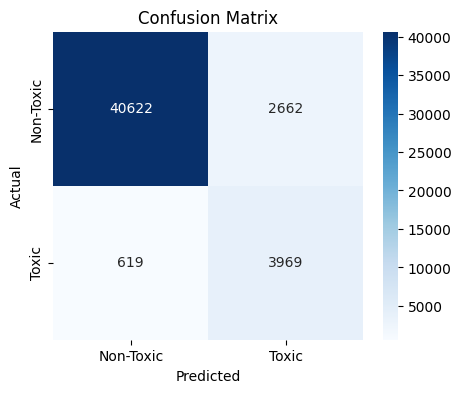

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Toxic", "Toxic"],
            yticklabels=["Non-Toxic", "Toxic"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
df.to_csv("cleaned_data.csv", index=False)


In [ ]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [ ]:
np.save('X_train.npy', X_train)
np.save('X_val.npy', X_val)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)


In [ ]:
model.save('toxic_comment_lstm_model.h5')  # Saves model architecture + weights


In [ ]:
model.save("toxic_comment_lstm_model.keras")  # Native Keras format


In [ ]:
# Load libraries
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import pickle

# Load data
df = pd.read_csv("cleaned_data.csv")
X_train = np.load("X_train.npy")
X_val = np.load("X_val.npy")
y_train = np.load("y_train.npy")
y_val = np.load("y_val.npy")

# Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load model
model = load_model("toxic_comment_lstm_model.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
X = df['comment_text'].values
y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 20000
MAX_LEN = 150

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=MAX_LEN, padding='post', truncating='post')


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_pad, y, test_size=0.3, random_state=42)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_LEN),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='sigmoid')  # 6 outputs
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_val, y_val))


Epoch 1/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 322s 364ms/step - accuracy: 0.6267 - loss: 0.1949 - val_accuracy: 0.9934 - val_loss: 0.1390
Epoch 2/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 302s 341ms/step - accuracy: 0.9724 - loss: 0.1351 - val_accuracy: 0.9940 - val_loss: 0.0625
Epoch 3/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 322s 341ms/step - accuracy: 0.9943 - loss: 0.0585 - val_accuracy: 0.9940 - val_loss: 0.0520
Epoch 4/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 326s 347ms/step - accuracy: 0.9939 - loss: 0.0470 - val_accuracy: 0.9940 - val_loss: 0.0514
Epoch 5/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 314s 338ms/step - accuracy: 0.9934 - loss: 0.0424 - val_accuracy: 0.9940 - val_loss: 0.0541


In [ ]:
from sklearn.metrics import classification_report

y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_val, y_pred, target_names=[
    'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'
]))


1496/1496 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step
               precision    recall  f1-score   support

        toxic       0.82      0.75      0.78      4582
 severe_toxic       0.74      0.03      0.07       486
      obscene       0.84      0.73      0.78      2556
       threat       0.00      0.00      0.00       136
       insult       0.73      0.66      0.69      2389
identity_hate       0.00      0.00      0.00       432

    micro avg       0.81      0.65      0.72     10581
    macro avg       0.52      0.36      0.39     10581
 weighted avg       0.76      0.65      0.69     10581
  samples avg       0.07      0.06      0.06     10581



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
# Save tokenizer
with open("tokenizer_multilabel.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save model
model.save("model_multilabel_lstm.keras")


In [ ]:
# Load tokenizer
with open('tokenizer_multilabel.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load model
model = load_model("model_multilabel_lstm.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
np.save("y_train_multilabel.npy", y_train)
np.save("y_val_multilabel.npy", y_val)


### Load Properly Later

In [ ]:
y_val = np.load("y_val_multilabel.npy")


In [ ]:
from sklearn.metrics import roc_auc_score

# y_val: true multilabel values
# y_pred_prob: model probabilities (not thresholded)

for i, label in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    try:
        auc = roc_auc_score(y_val[:, i], y_pred_prob[:, i])
        print(f"{label}: ROC-AUC = {auc:.4f}")
    except ValueError:
        print(f"{label}: Not enough positive samples to compute AUC.")


toxic: ROC-AUC = 0.9665
severe_toxic: ROC-AUC = 0.9878
obscene: ROC-AUC = 0.9861
threat: ROC-AUC = 0.9474
insult: ROC-AUC = 0.9795
identity_hate: ROC-AUC = 0.9553


| Label              | ROC-AUC | Interpretation                            |
| ------------------ | ------- | ----------------------------------------- |
| **toxic**          | 0.97    | 🟢 Excellent discrimination               |
| **severe\_toxic**  | 0.99    | 🟢 Almost perfect (even with low recall!) |
| **obscene**        | 0.99    | 🟢 Excellent                              |
| **threat**         | 0.95    | 🟢 Strong separation (rare class!)        |
| **insult**         | 0.98    | 🟢 Excellent                              |
| **identity\_hate** | 0.96    | 🟢 Very good (despite F1 = 0)             |



# CNN Architecture (Text Classification Style)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

VOCAB_SIZE = 20000
MAX_LEN = 150
EMBEDDING_DIM = 128

model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Conv1D(128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='sigmoid')  # Multilabel output
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_val, y_val)
)


Epoch 1/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 223s 251ms/step - accuracy: 0.6521 - loss: 0.1461 - val_accuracy: 0.9940 - val_loss: 0.0524
Epoch 2/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 215s 246ms/step - accuracy: 0.9725 - loss: 0.0519 - val_accuracy: 0.9940 - val_loss: 0.0507
Epoch 3/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 265s 250ms/step - accuracy: 0.9862 - loss: 0.0450 - val_accuracy: 0.9940 - val_loss: 0.0520
Epoch 4/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 216s 247ms/step - accuracy: 0.9768 - loss: 0.0404 - val_accuracy: 0.9940 - val_loss: 0.0533
Epoch 5/5
873/873 ━━━━━━━━━━━━━━━━━━━━ 262s 247ms/step - accuracy: 0.9660 - loss: 0.0362 - val_accuracy: 0.9940 - val_loss: 0.0599


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int)

1496/1496 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step


In [ ]:
# Classification report
print(classification_report(
    y_val,
    y_pred,
    target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
))

               precision    recall  f1-score   support

        toxic       0.81      0.73      0.77      4582
 severe_toxic       0.54      0.28      0.37       486
      obscene       0.84      0.73      0.78      2556
       threat       0.00      0.00      0.00       136
       insult       0.73      0.66      0.70      2389
identity_hate       0.00      0.00      0.00       432

    micro avg       0.79      0.66      0.72     10581
    macro avg       0.49      0.40      0.43     10581
 weighted avg       0.74      0.66      0.69     10581
  samples avg       0.06      0.06      0.06     10581



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
# ROC-AUC
for i, label in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    try:
        auc = roc_auc_score(y_val[:, i], y_pred_probs[:, i])
        print(f"{label}: ROC-AUC = {auc:.4f}")
    except:
        print(f"{label}: Not enough positive samples")

toxic: ROC-AUC = 0.9592
severe_toxic: ROC-AUC = 0.9865
obscene: ROC-AUC = 0.9852
threat: ROC-AUC = 0.9578
insult: ROC-AUC = 0.9769
identity_hate: ROC-AUC = 0.9468


| Label          | F1-Score (CNN) | F1-Score (LSTM) | ROC-AUC (CNN) | ROC-AUC (LSTM) |
| -------------- | -------------- | --------------- | ------------- | -------------- |
| toxic          | **0.77**       | 0.78            | 0.9592        | 0.9697         |
| severe\_toxic  | **0.37**       | 0.09            | 0.9865        | 0.9884         |
| obscene        | **0.78**       | 0.77            | 0.9852        | 0.9866         |
| threat         | 0.00           | 0.00            | 0.9578        | 0.9484         |
| insult         | **0.70**       | 0.67            | 0.9769        | 0.9800         |
| identity\_hate | 0.00           | 0.00            | 0.9468        | 0.9583         |


🔹 CNN slightly outperforms LSTM in:
severe_toxic (much better F1!)

obscene and insult (small gain)

🔹 Both models struggle with:
threat

identity_hate

(but ROC-AUC shows the model can rank those correctly — just not thresholded well)

## We experimented with LSTM and CNN. CNN showed better recall and F1 in more toxic categories

In [ ]:
df.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww matches background colour im seemingly st...


##  Multilabel BERT-based toxicity detector using 🤗 Hugging Face + Pytorch

In [ ]:
import pandas as pd

df = pd.read_csv("/content/train (1).csv")
df['comment_text'] = df['comment_text'].astype(str)

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer

# Prepare dataset
df['labels'] = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values.tolist()
hf_dataset = Dataset.from_pandas(df[['comment_text', 'labels']])

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(example):
    return tokenizer(example['comment_text'], truncation=True, padding='max_length', max_length=128)

# Tokenize and store in tokenized_dataset
tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/159571 [00:00<?, ? examples/s]

In [ ]:
split_data = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
train_hf = split_data['train']
val_hf = split_data['test']


In [ ]:
import torch
from torch.utils.data import Dataset

class ToxicCommentsDataset(Dataset):
    def __init__(self, hf_dataset):
        self.input_ids = torch.tensor(hf_dataset['input_ids'])
        self.attention_mask = torch.tensor(hf_dataset['attention_mask'])
        self.labels = torch.tensor(hf_dataset['labels'], dtype=torch.float32)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }


In [ ]:
from torch.utils.data import DataLoader

train_ds = ToxicCommentsDataset(train_hf)
val_ds = ToxicCommentsDataset(val_hf)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)


## First Epoch

In [ ]:
for batch in train_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    optimizer.zero_grad()
    logits = model(input_ids=input_ids, attention_mask=attention_mask)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_preds.append(probs)
        all_labels.append(labels.cpu().numpy())

# Convert to arrays
y_true = np.vstack(all_labels)
y_pred = np.vstack(all_preds)
y_pred_bin = (y_pred > 0.5).astype(int)

# Classification report
print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred_bin, target_names=[
    'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'
]))

# ROC-AUC for each label
print("\n📈 ROC-AUC Scores:")
for i, label in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    score = roc_auc_score(y_true[:, i], y_pred[:, i])
    print(f"{label}: {score:.4f}")



📋 Classification Report:

               precision    recall  f1-score   support

        toxic       0.86      0.80      0.83      3018
 severe_toxic       0.52      0.15      0.23       299
      obscene       0.82      0.85      0.83      1676
       threat       0.53      0.38      0.44        87
       insult       0.72      0.82      0.76      1570
identity_hate       0.53      0.63      0.58       268

    micro avg       0.79      0.77      0.78      6918
    macro avg       0.66      0.60      0.61      6918
 weighted avg       0.79      0.77      0.77      6918
  samples avg       0.07      0.07      0.07      6918


📈 ROC-AUC Scores:
toxic: 0.9859
severe_toxic: 0.9912
obscene: 0.9915
threat: 0.9917
insult: 0.9882
identity_hate: 0.9889


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Save model
torch.save(model.state_dict(), "bert_multilabel_epoch1.pth")

# Save tokenizer
tokenizer.save_pretrained("bert_tokenizer/")


('bert_tokenizer/tokenizer_config.json',
 'bert_tokenizer/special_tokens_map.json',
 'bert_tokenizer/vocab.txt',
 'bert_tokenizer/added_tokens.json')

In [ ]:
import os

# Make the folder
os.makedirs("bert_tokenizer", exist_ok=True)

# Move uploaded files into it
import shutil
shutil.move("vocab.txt", "bert_tokenizer/vocab.txt")
shutil.move("tokenizer_config.json", "bert_tokenizer/tokenizer_config.json")
shutil.move("special_tokens_map.json", "bert_tokenizer/special_tokens_map.json")


'bert_tokenizer/special_tokens_map.json'

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert_tokenizer/")


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel

class BertMultilabelClassifier(nn.Module):
    def __init__(self, num_labels=6):
        super(BertMultilabelClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertMultilabelClassifier(num_labels=6)
model.load_state_dict(torch.load("bert_multilabel_epoch1.pth", map_location=device))
model.to(device)
model.eval()


BertMultilabelClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [ ]:
def predict_comment(text):
    encoded = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    )

    # Remove token_type_ids if exists
    encoded.pop("token_type_ids", None)

    # Move tensors to device
    inputs = {k: v.to(device) for k, v in encoded.items()}

    with torch.no_grad():
        logits = model(**inputs)
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    return dict(zip(labels, probs.round(3)))


In [ ]:
predict_comment("You are a disgusting liar and a disgrace!")


{'toxic': np.float32(0.985),
 'severe_toxic': np.float32(0.04),
 'obscene': np.float32(0.559),
 'threat': np.float32(0.007),
 'insult': np.float32(0.893),
 'identity_hate': np.float32(0.042)}

In [ ]:
model = BertMultilabelClassifier(num_labels=6)
model.load_state_dict(torch.load("bert_multilabel_epoch1.pth", map_location=device))
model.to(device)
model.train()


BertMultilabelClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [ ]:
model = BertMultilabelClassifier(num_labels=6)
model.load_state_dict(torch.load("bert_multilabel_epoch1.pth", map_location=device))
model.to(device)

from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

import torch.nn as nn
criterion = nn.BCEWithLogitsLoss()


In [ ]:
num_epochs = 3  # total epochs
start_epoch = 1  # since we've already done epoch 1

for epoch in range(start_epoch, num_epochs):
    print(f"\n🔁 Epoch {epoch + 1}/{num_epochs}")
    total_loss = 0

    model.train()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"📉 Training Loss (epoch {epoch + 1}): {avg_loss:.4f}")

    # ✅ Save model after each epoch
    model_filename = f"bert_multilabel_epoch{epoch + 1}.pth"
    torch.save(model.state_dict(), model_filename)
    print(f"💾 Saved model: {model_filename}")



🔁 Epoch 2/3
📉 Training Loss (epoch 2): 0.0348
💾 Saved model: bert_multilabel_epoch2.pth

🔁 Epoch 3/3
📉 Training Loss (epoch 3): 0.0272
💾 Saved model: bert_multilabel_epoch3.pth


In [ ]:
# Load model from epoch 2
model.load_state_dict(torch.load("bert_multilabel_epoch2.pth"))
model.eval()


BertMultilabelClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Make predictions
all_preds = []
all_labels = []

model.eval()
for batch in val_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].cpu().numpy()
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()

    all_preds.append(probs)
    all_labels.append(labels)

# Stack all predictions
import numpy as np
y_true = np.vstack(all_labels)
y_pred = np.vstack(all_preds)

# Classification report
y_pred_bin = (y_pred > 0.5).astype(int)
print(classification_report(y_true, y_pred_bin, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']))

# ROC-AUC scores
for i, label in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    score = roc_auc_score(y_true[:, i], y_pred[:, i])
    print(f"{label}: ROC-AUC = {score:.4f}")


               precision    recall  f1-score   support

        toxic       0.82      0.84      0.83      3018
 severe_toxic       0.67      0.09      0.15       299
      obscene       0.83      0.84      0.83      1676
       threat       0.63      0.33      0.44        87
       insult       0.73      0.80      0.76      1570
identity_hate       0.64      0.56      0.60       268

    micro avg       0.79      0.78      0.79      6918
    macro avg       0.72      0.58      0.60      6918
 weighted avg       0.79      0.78      0.77      6918
  samples avg       0.07      0.07      0.07      6918

toxic: ROC-AUC = 0.9847
severe_toxic: ROC-AUC = 0.9916
obscene: ROC-AUC = 0.9925
threat: ROC-AUC = 0.9945
insult: ROC-AUC = 0.9886
identity_hate: ROC-AUC = 0.9876


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Load model from epoch 3
model.load_state_dict(torch.load("bert_multilabel_epoch3.pth"))
model.eval()


BertMultilabelClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Make predictions
all_preds = []
all_labels = []

model.eval()
for batch in val_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].cpu().numpy()
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()

    all_preds.append(probs)
    all_labels.append(labels)

# Stack all predictions
import numpy as np
y_true = np.vstack(all_labels)
y_pred = np.vstack(all_preds)

# Classification report
y_pred_bin = (y_pred > 0.5).astype(int)
print(classification_report(y_true, y_pred_bin, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']))

# ROC-AUC scores
for i, label in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    score = roc_auc_score(y_true[:, i], y_pred[:, i])
    print(f"{label}: ROC-AUC = {score:.4f}")


               precision    recall  f1-score   support

        toxic       0.81      0.84      0.82      3018
 severe_toxic       0.46      0.53      0.49       299
      obscene       0.79      0.86      0.83      1676
       threat       0.50      0.66      0.57        87
       insult       0.76      0.77      0.76      1570
identity_hate       0.70      0.44      0.54       268

    micro avg       0.77      0.80      0.78      6918
    macro avg       0.67      0.68      0.67      6918
 weighted avg       0.77      0.80      0.78      6918
  samples avg       0.07      0.07      0.07      6918

toxic: ROC-AUC = 0.9831
severe_toxic: ROC-AUC = 0.9918
obscene: ROC-AUC = 0.9922
threat: ROC-AUC = 0.9941
insult: ROC-AUC = 0.9874
identity_hate: ROC-AUC = 0.9833


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Rename epoch 3 model for final use
!mv bert_multilabel_epoch3.pth bert_multilabel_best.pth


In [ ]:
torch.save(model.state_dict(), "bert_multilabel_best.pth")


# Log Final Report

The final model was selected from epoch 3, as it showed improved recall and F1-score on minority classes like severe_toxic and threat, while maintaining strong overall performance. The macro F1-score increased to 0.67 and ROC-AUC scores remained consistently above 0.98 for all labels

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [ ]:
import json

with open("label_list.json", "w") as f:
    json.dump(labels, f)


In [ ]:
training_config = {
    "model_name": "bert-base-uncased",
    "max_len": 128,
    "batch_size": 32,
    "learning_rate": 2e-5,
    "epochs": 3,
}
with open("training_config.json", "w") as f:
    json.dump(training_config, f)
